In [1]:
import caiman as cm
import numpy as np
import matplotlib.pyplot as plt
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf, params
from caiman.utils.utils import download_demo

In [2]:
mv = cm.load('data/data.tif')
mv.shape

(3000, 170, 170)

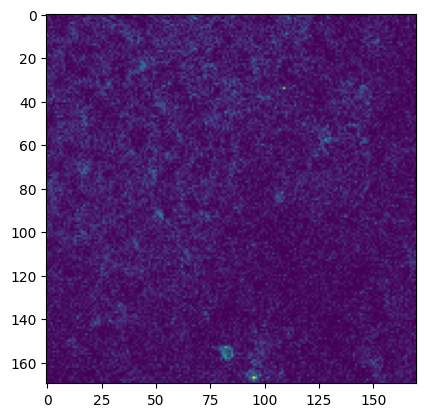

In [3]:
plt.imshow(mv[0])

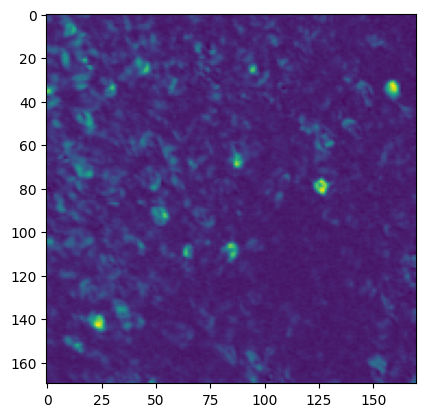

In [4]:
corr = cm.local_correlations(mv, swap_dim=False)
plt.imshow(corr)

In [5]:
# general dataset-dependent parameters
fr = 30                     # imaging rate in frames per second
decay_time = 0.4            # length of a typical transient in seconds
dxy = (2., 2.)              # spatial resolution in x and y in (um per pixel)

# motion correction parameters
strides = (48, 48)          # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)         # overlap between patches (width of patch = strides+overlaps)
max_shifts = (6,6)          # maximum allowed rigid shifts (in pixels)
max_deviation_rigid = 3     # maximum shifts deviation allowed for patch with respect to rigid shifts
pw_rigid = True             # flag for performing non-rigid motion correction

# CNMF parameters for source extraction and deconvolution
p = 1                       # order of the autoregressive system (set p=2 if there is visible rise time in data)
gnb = 2                     # number of global background components (set to 1 or 2)
merge_thr = 0.85            # merging threshold, max correlation allowed
bas_nonneg = True           # enforce nonnegativity constraint on calcium traces (technically on baseline)
rf = 15                     # half-size of the patches in pixels (patch width is rf*2 + 1)
stride_cnmf = 10             # amount of overlap between the patches in pixels (overlap is stride_cnmf+1) 
K = 4                       # number of components per patch
gSig = np.array([4, 4])     # expected half-width of neurons in pixels (Gaussian kernel standard deviation)
gSiz = 2*gSig + 1           # Gaussian kernel width and hight
method_init = 'greedy_roi'  # initialization method (if analyzing dendritic data see demo_dendritic.ipynb)
ssub = 1                    # spatial subsampling during initialization 
tsub = 1                    # temporal subsampling during intialization

# parameters for component evaluation
min_SNR = 2.0               # signal to noise ratio for accepting a component
rval_thr = 0.85             # space correlation threshold for accepting a component
cnn_thr = 0.99              # threshold for CNN based classifier
cnn_lowest = 0.1            # neurons with cnn probability lower than this value are rejected

In [6]:
parameter_dict = {'fnames': 'data/data.tif',
                  'fr': fr,
                  'dxy': dxy,
                  'decay_time': decay_time,
                  'strides': strides,
                  'overlaps': overlaps,
                  'max_shifts': max_shifts,
                  'max_deviation_rigid': max_deviation_rigid,
                  'pw_rigid': pw_rigid,
                  'p': p,
                  'nb': gnb,
                  'rf': rf,
                  'K': K, 
                  'gSig': gSig,
                  'gSiz': gSiz,
                  'stride': stride_cnmf,
                  'method_init': method_init,
                  'rolling_sum': True,
                  'only_init': True,
                  'ssub': ssub,
                  'tsub': tsub,
                  'merge_thr': merge_thr, 
                  'bas_nonneg': bas_nonneg,
                  'min_SNR': min_SNR,
                  'rval_thr': rval_thr,
                  'use_cnn': True,
                  'min_cnn_thr': cnn_thr,
                  'cnn_lowest': cnn_lowest}

parameters = params.CNMFParams(params_dict=parameter_dict) # CNMFParams is the parameters class

In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


#### Motion Correction

In [7]:
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf, params

In [8]:
mot_correct = MotionCorrect('data/data.tif', **parameters.motion)
mot_correct.motion_correct(save_movie=True)
mot = cm.load(mot_correct.mmap_file)

Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


In [9]:
mot_max = np.max(mot, axis=0)
mot_corr = cm.local_correlations(mot, swap_dim=False)

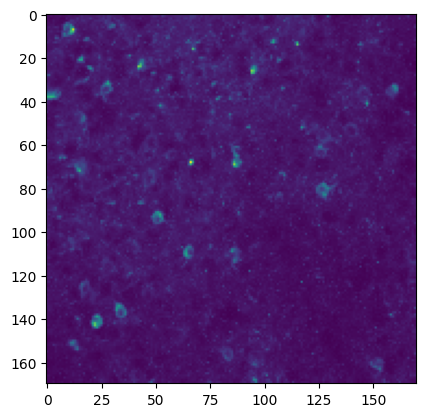

In [10]:
plt.imshow(mot_max)

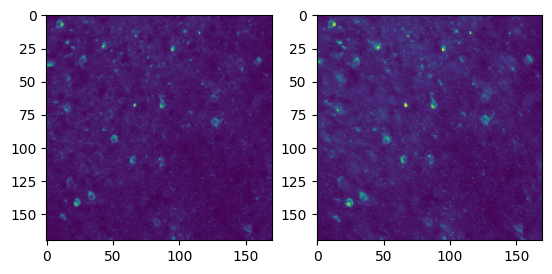

In [11]:
plt.subplot(121)
plt.imshow(mot_max)

plt.subplot(122)
plt.imshow(np.max(mv, axis=0))

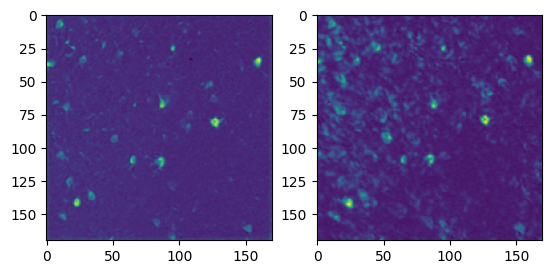

In [12]:
plt.subplot(121)
plt.imshow(mot_corr)

plt.subplot(122)
plt.imshow(corr)

In [13]:
cnmf_model = cnmf.CNMF(1, params=parameters,)

In [14]:
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour, nb_view_quilt
cnmf_patch_width = cnmf_model.params.patch['rf']*2 + 1
cnmf_patch_overlap = cnmf_model.params.patch['stride'] + 1
cnmf_patch_stride = cnmf_patch_width - cnmf_patch_overlap
print(f'Patch width: {cnmf_patch_width} , Stride: {cnmf_patch_stride}, Overlap: {cnmf_patch_overlap}');

# plot the patches
patch_ax = nb_view_quilt(mot_corr, 
                      cnmf_model.params.patch['rf'], 
                      cnmf_model.params.patch['stride']);

Patch width: 31 , Stride: 20, Overlap: 11


In [15]:
border_to_0 = 0 if mot_correct.border_nan == 'copy' else mot_correct.border_to_0 # trim border against NaNs
mc_memmapped_fname = cm.save_memmap(mot_correct.mmap_file, 
                                        base_name='memmap_', 
                                        order='C',
                                        border_to_0=border_to_0,  # exclude borders, if that was done
                                        )

Yr, dims, num_frames = cm.load_memmap(mc_memmapped_fname)
images = np.reshape(Yr.T, [num_frames] + list(dims), order='F')

In [16]:
cnmf_model.estimates.plot_contours_nb(img=mot_max);

Error with bokeh plotter.
Using non-interactive plot as fallback


ValueError: scipy.sparse does not support dtype object. The only supported types are: bool_, int8, uint8, int16, uint16, intc, uintc, int32, uint32, int64, uint64, float32, float64, longdouble, complex64, complex128, clongdouble.

In [17]:
new_parameters = {'rf': 24, 'K': 2}
cnmf_model.params.change_params(params_dict=new_parameters)
cnmf_model.fit(images)
cnmf_model.estimates.plot_contours_nb(img=mot_max);

In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


In [19]:
new_parameters = {'rf': 24, 'K': 2}
cnmf_model.params.change_params(params_dict=new_parameters)
cnmf_model.fit(images)
cnmf_model.estimates.plot_contours_nb(img=mot_max);

In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


IndexError: index 43 is out of bounds for axis 0 with size 28